Автор: Лейман М.А.   
Дата создания: 22.03.2025  

# Задание ZALA  
## 4. Детектирование множества объектов
### Модель __YOLO custom__   

Модель детектирует объекты как один класс (автомобиль, самолёт, корабль)   

Датасеты: DOTA, UAVOD  
Отфильтрованы классы (автомобиль, самолёт, корабль)  


## Импорты

In [1]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import torch
from matplotlib import rcParams
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = (14,6)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import random
from torch.utils.data import random_split
from PIL import ImageOps
from tqdm import tqdm


print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/devsTraining/zala_task


## Проверка GPU

In [2]:
# Устанавливаем device:  gpu или cpu


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.6.0+cu124
версия  cuDNN:           90100
Thu Apr 24 17:52:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
|  0%   50C    P8             23W /  170W |     965MiB /  12288MiB |     40%      Default |
|                                         

In [3]:
# Получаем текущую директорию
path_dir = os.getcwd()
print("Текущая директория:", path_dir)

DATA_DIR = os.path.abspath(os.path.join(path_dir, 'dataset'))
print("Путь к dataset:", DATA_DIR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Текущая директория: /home/maksim/develops/python/devsTraining/zala_task
Путь к dataset: /home/maksim/develops/python/devsTraining/zala_task/dataset


 ## ДОП. ФУНКЦИИ

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageOps
import numpy as np
import torch


def draw_boxes(img_tensor, pred_tensor, true_tensor, S=16, B=2, C=1, threshold=0.5):
    """  
        Просмотр изображения в процессе валидации.
        Отрисовывает боксы предсказанные и реальные.
    """
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    h, w = img.shape[:2]

    # ===============     Карты уверенности 
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    gt_map = true_tensor[..., 4].cpu().numpy()
    im0 = axes[0].imshow(gt_map, cmap='hot', interpolation='nearest')
    axes[0].set_title("Target карта доверия")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    pred_map = np.zeros((S, S))
    for y in range(S):
        for x in range(S):
            for b in range(B):
                base = b * (5 + C)
                conf = pred_tensor[y, x, base + 4].item()
                pred_map[y, x] = max(pred_map[y, x], conf)

    im1 = axes[1].imshow(pred_map, cmap='hot', interpolation='nearest')
    axes[1].set_title("PRED карта доверия")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    # ============    Отрисовка боксов 
    cell_size_x = w / S
    cell_size_y = h / S

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)

    for y in range(S):
        for x in range(S):
            # ============    GT боксы 
            for b in range(B):
                base = b * (5 + C)
                if true_tensor[y, x, base + 4] > 0:
                    tx, ty, tw, th = true_tensor[y, x, base:base+4]
                    abs_x = (x + tx.item()) * cell_size_x
                    abs_y = (y + ty.item()) * cell_size_y
                    abs_w = tw.item() * w
                    abs_h = th.item() * h
                    rect = patches.Rectangle((abs_x - abs_w / 2, abs_y - abs_h / 2),
                                             abs_w, abs_h,
                                             linewidth=2, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)

            # ============   Предсказанные боксы: только 1 с max confidence 
            best_conf = 0
            best_box = None
            for b in range(B):
                base = b * (5 + C)
                conf = pred_tensor[y, x, base + 4].item()
                if conf > best_conf and conf > threshold:
                    px, py, pw, ph = pred_tensor[y, x, base:base+4]
                    if not (0 <= px <= 1 and 0 <= py <= 1 and 0.01 <= pw <= 1.0 and 0.01 <= ph <= 1.0):
                        continue
                    best_conf = conf
                    best_box = (px.item(), py.item(), pw.item(), ph.item())

            if best_box:
                px, py, pw, ph = best_box
                abs_x = (x + px) * cell_size_x
                abs_y = (y + py) * cell_size_y
                abs_w = pw * w
                abs_h = ph * h

                if abs_w < 3 or abs_h < 3 or abs_w > w or abs_h > h:
                    continue

                rect = patches.Rectangle((abs_x - abs_w / 2, abs_y - abs_h / 2),
                                         abs_w, abs_h,
                                         linewidth=1.5, edgecolor='red', linestyle='--', facecolor='none')
                ax.add_patch(rect)
                ax.text(abs_x - abs_w / 2, abs_y - abs_h / 2 - 4,
                        f"{best_conf:.2f}", color='red', fontsize=8)

    # --- Сетка ---
    for i in range(1, S):
        ax.axhline(i * cell_size_y, color='gray', linestyle=':', linewidth=0.5)
        ax.axvline(i * cell_size_x, color='gray', linestyle=':', linewidth=0.5)

    plt.axis('off')
    plt.title("Green = Реальные, Red = Предсказанные")
    plt.show()



def yolo_collate_fn(batch):
    """  
        Функция объединения  для DataLoader.

        Принимает батч данных,  кортеж (изображение, таргеты),
        и объединяет их в батч-тензоры для обучения модели.

    Возвращает:
        imgs (Tensor): Батч изображений с формой [batch_size, C, H, W].
        targets (Tensor): Батч разметок с формой [batch_size, S, S, B*(5 + C)].
    """
    imgs = [img for img, target in batch]
    targets = [target for img, target in batch]

    imgs = torch.stack(imgs, dim=0)
    targets = torch.stack(targets, dim=0)  # [batch_size, S, S, 12]
    return imgs, targets




def resize_with_padding(img, desired_size=512):
    """  
        Меняет размер изображения
    """

    old_size = img.size  # (width, height)
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    img = img.resize(new_size, Image.BILINEAR)

    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)

    new_img = ImageOps.expand(img, padding, fill=(0, 0, 0))
    return new_img, ratio, padding


def extract_boxes(preds, targets, S, B, C, device):
    """  
        Извлекает предсказанные и истинные ограничивающие боксы (bounding boxes) из выходов YOLO и таргетов.

        Проходит по каждому элементу батча и по каждой ячейке сетки SxS. 
        Для каждого из B предсказанных боксов извлекает те, у которых в targets confidence > 0
        Возвращает пары (предсказанный бокс, истинный бокс) для  расчёта метрик.

    Аргументы:
        preds (Tensor): Предсказания модели формы [batch_size, S, S, B*(5+C)].
        targets (Tensor): Истинные значения формы [batch_size, S, S, B*(5+C)].
        S (int): Размер сетки (обычно 7 или 16).
        B (int): Количество предсказанных боксов на ячейку.
        C (int): Количество классов.
        device : Устройство, на которое перемещаются выходные тензоры.

    Возвращает:
        pred_boxes (Tensor): Предсказанные боксы, форма [N, 4], где N — количество найденных объектов.
        true_boxes (Tensor): Истинные боксы, форма [N, 4].
        Если объектов не найдено, возвращает (None, None).
    """


    batch_size = preds.size(0)
    pred_boxes = []
    true_boxes = []

    for i in range(batch_size):
        for y in range(S):
            for x in range(S):
                for b in range(B):
                    base = b * (5 + C)
                    if targets[i, y, x, base + 4] > 0:
                        pred_box = preds[i, y, x, base:base+4]
                        true_box = targets[i, y, x, base:base+4]
                        pred_boxes.append(pred_box)
                        true_boxes.append(true_box)

    if len(pred_boxes) == 0:
        return None, None

    pred_boxes = torch.stack(pred_boxes).to(device)
    true_boxes = torch.stack(true_boxes).to(device)

    return pred_boxes, true_boxes


## ДАТАСЕТ

In [5]:
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
import random

class SyntheticYOLODataset(Dataset):
    """
        Генератор синтетических изображений с белыми прямоугольниками и случайным шумом
        до B объектов
        шум: круги, треугольники, точки
    """

    def __init__(self, size=1000, img_size=512, S=16, B=2, C=1):
        self.size = size
        self.img_size = img_size
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
        label = np.zeros((self.S, self.S, self.B * (5 + self.C)), dtype=np.float32)

        num_objects = random.randint(1, self.B)
        used_cells = set()

        for obj_idx in range(num_objects):
            box_w = random.uniform(0.1, 0.4) * self.img_size
            box_h = random.uniform(0.1, 0.4) * self.img_size
            center_x = random.uniform(box_w / 2, self.img_size - box_w / 2)
            center_y = random.uniform(box_h / 2, self.img_size - box_h / 2)

            x1 = int(center_x - box_w / 2)
            y1 = int(center_y - box_h / 2)
            x2 = int(center_x + box_w / 2)
            y2 = int(center_y + box_h / 2)

            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), -1)

            x_center_norm = center_x / self.img_size
            y_center_norm = center_y / self.img_size
            w_norm = box_w / self.img_size
            h_norm = box_h / self.img_size

            grid_x = int(x_center_norm * self.S)
            grid_y = int(y_center_norm * self.S)

            if (grid_y, grid_x) in used_cells:
                continue
            used_cells.add((grid_y, grid_x))

            class_id = random.randint(0, self.C - 1)
            base = obj_idx * (5 + self.C)

            label[grid_y, grid_x, base + 0] = x_center_norm * self.S - grid_x
            label[grid_y, grid_x, base + 1] = y_center_norm * self.S - grid_y
            label[grid_y, grid_x, base + 2] = w_norm
            label[grid_y, grid_x, base + 3] = h_norm
            label[grid_y, grid_x, base + 4] = 1
            label[grid_y, grid_x, base + 5 + class_id] = 1

        # Шум: круги и треугольники
        num_shapes = random.randint(1, 5)
        for _ in range(num_shapes):
            shape_type = random.choice(['circle', 'triangle'])
            center = (
                random.randint(0, self.img_size),
                random.randint(0, self.img_size)
            )
            color = (random.randint(100, 200),) * 3
            size = random.randint(20, 50)

            if shape_type == 'circle':
                cv2.circle(img, center, size, color, -1)
            else:
                pt1 = center
                pt2 = (center[0] + size, center[1] + size)
                pt3 = (center[0] - size, center[1] + size)
                triangle_cnt = np.array([pt1, pt2, pt3])
                cv2.drawContours(img, [triangle_cnt], 0, color, -1)

        # Шум: светлые точки
        num_dots = random.randint(100, 300)
        for _ in range(num_dots):
            x = random.randint(0, self.img_size - 1)
            y = random.randint(0, self.img_size - 1)
            brightness = random.randint(180, 255)
            img[y, x] = (brightness, brightness, brightness)

        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # [C, H, W]

        return torch.tensor(img), torch.tensor(label)


In [6]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class YOLORealDataset(Dataset):
    """
    Кастомный PyTorch Dataset для загрузки изображений и аннотаций в формате YOLO.

    Параметры:
        images_path : str - Путь к директории с изображениями.
        
        labels_path : str - Путь к директории с аннотациями в формате YOLO (.txt файлы).
        
        S : int - Размер сетки (16),  для деления изображения на ячейки.
        
        B : int - Количество предсказываемых боксов на ячейку.
        
        C : int - Количество классов объектов.
        
        transform : torchvision.transforms или None  - Аугментации и преобразования, применяемые к изображениям.
        
        image_size : int - Размер изображения (ширина и высота) после изменения размера. По умолчанию 512.
    
    Атрибуты:
        image_files : list - Список имён файлов изображений.
        
        resize : torchvision.transforms.Resize -  Преобразование для изменения размера изображений.
    """

    def __init__(self, images_path, labels_path, S=16, B=2, C=1, transform=None, image_size=512):
        self.images_path = images_path
        self.labels_path = labels_path
        self.S = S
        self.B = B
        self.C = C
        self.transform = transform
        self.image_files = sorted(os.listdir(images_path))

        # Преобразование для изменения размера
        self.resize = T.Resize((image_size, image_size))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_name)
        label_path = os.path.join(self.labels_path, img_name.replace('.jpg', '.txt'))

        # Загружаем и ресайзим изображение
        img = Image.open(img_path).convert('RGB')
        img = self.resize(img)
        img = torch.tensor(np.array(img) / 255.0, dtype=torch.float32).permute(2, 0, 1)

        # Загружаем аннотации
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                x_center, y_center, w, h = map(float, parts[1:])
                labels.append([cls, x_center, y_center, w, h])

        # Формируем target
        target = torch.zeros(self.S, self.S, self.B * (5 + self.C))
        for label in labels:
            cls, x_center, y_center, w, h = label
            grid_x = int(min(x_center * self.S, self.S - 1e-5))
            grid_y = int(min(y_center * self.S, self.S - 1e-5))

            for b in range(self.B):
                base = b * (5 + self.C)
                target[grid_y, grid_x, base + 0] = x_center * self.S - grid_x  # dx
                target[grid_y, grid_x, base + 1] = y_center * self.S - grid_y  # dy
                target[grid_y, grid_x, base + 2] = w
                target[grid_y, grid_x, base + 3] = h
                target[grid_y, grid_x, base + 4] = 1
                target[grid_y, grid_x, base + 5] = 1

        # target = target.unsqueeze(0)

        if self.transform:
            img = self.transform(img)

        return img, target


## МОДЕЛЬ

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class YOLOv1(nn.Module):
    """
    Кастомная реализация модели YOLOv1 для детекции.

    Параметры:
    S : int - Размер сетки (разбиение изображения на SxS ячеек).

    B : int - Количество предсказываемых ограничивающих боксов (bounding boxes) на каждую ячейку.

    C : int - Количество классов объектов.

    Описание архитектуры:
    Состоит из сверточных слоев features для извлечения признаков с постепенным увеличением каналов и понижением разрешения.
    head — финальный сверточный блок, который формирует выходной тензор размером [batch_size, S, S, B*(5+C)].
    Выход:
    Тензор формы [batch_size, S, S, B*(5+C)]:
        Для каждой ячейки предсказываются B боксов и распределение вероятностей по C классам.
        Все выходы нормализованы с помощью сигмоиды для удобной интерпретации.
    """


    def __init__(self, S=16, B=2, C=1):
        super(YOLOv1, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        out_channels = B * (5 + C)

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
        )

        self.head = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Conv2d(512, out_channels, 1)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        x = x.permute(0, 2, 3, 1)

        # Разделим каналы
        B, S, _, _ = x.shape
        x = x.view(B, self.S, self.S, self.B, 5 + self.C)


        # Ограничения
        x[..., 0:2] = torch.sigmoid(x[..., 0:2])  # x, y
        x[..., 2:4] = torch.sigmoid(x[..., 2:4])     # w, h
        x[..., 4] = torch.sigmoid(x[..., 4])      # уверенсть
        x[..., 5:] = torch.sigmoid(x[..., 5:])    # вероятность класса

        return x.view(B, self.S, self.S, -1)



In [8]:
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """
        Блок, реализующий два свёрточных слоя с пропуском (skip connection).

        Параметры:
        in_channels : int - Количество входных каналов (каналов изображения или признаков).

    Вход:
        Тензор с размерами [batch_size, C, H, W], где B — размер батча, C — количество каналов, H — высота, W — ширина.

    Выход:
        Тензор с размерами [batch_size, C, H2, W2].
    """

    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.BatchNorm2d(in_channels),
        )

    def forward(self, x):
        return F.leaky_relu(self.conv(x) + x, 0.1)


class YOLOv2(nn.Module):
    """
    Модель YOLOv2 для объектного детектирования.

    Параметры:
    S : int, по умолчанию 16 - Размер сетки (разбиение изображения на SxS ячеек).

    B : int, по умолчанию 2 - Количество предсказываемых ограничивающих боксов (bounding boxes) на каждую ячейку.

    C : int, по умолчанию 1 - Количество классов объектов.

    Архитектура:
        Состоит из нескольких свёрточных блоков, которые включают в себя стандартные свёртки и свёртки с остаточными блоками (ResidualBlock).
        Применяются свёртки с уменьшением разрешения (stride=2) для понижения разрешения на каждом уровне.
        Последний блок "head" включает остаточный блок и дополнительные свёртки, чтобы сформировать выходной тензор.
        Выходной тензор содержит предсказания для ограничивающих боксов (x, y, w, h, уверенность) и вероятности классов для каждой ячейки сетки.
    
    Выход:
        Тензор формы [batch_size, S, S, B*(5+C)], где:
            batch_size — размер батча
            S — размер сетки (SxS)
            5 — количество параметров для каждого бокса: (x, y, w, h, уверенность)
            C — количество классов (вероятности для каждого из классов).
    """



    def __init__(self, S=16, B=2, C=1):
        super(YOLOv2, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        out_channels = B * (5 + C)

        def conv_block(in_ch, out_ch, use_res=False):
            layers = [
                nn.Conv2d(in_ch, out_ch, 3, padding=1, stride=1),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.1),
            ]
            if use_res:
                layers.append(ResidualBlock(out_ch))
            layers.append(nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1))  
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(nn.LeakyReLU(0.1))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            conv_block(3, 16),
            conv_block(16, 32),
            conv_block(32, 64, use_res=True),
            conv_block(64, 128, use_res=True),
            conv_block(128, 256, use_res=True),
        )

        self.head = nn.Sequential(
            ResidualBlock(256),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.4),
            nn.Conv2d(512, out_channels, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        x = x.permute(0, 2, 3, 1)

        B, S, _, _ = x.shape
        x = x.view(B, self.S, self.S, self.B, 5 + self.C)

        x[..., 0:2] = torch.sigmoid(x[..., 0:2])  # x, y
        x[..., 2:4] = torch.sigmoid(x[..., 2:4])  # w, h
        x[..., 4] = torch.sigmoid(x[..., 4])      # уверенность
        x[..., 5:] = torch.sigmoid(x[..., 5:])    # вероятность класса

        return x.view(B, self.S, self.S, -1)
    

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)




## LOSS 

In [9]:
import torch.nn.functional as F

def yolo_loss(pred, target, S=16, B=2, C=3, lambda_coord=5, lambda_noobj=0.5):
    """
        Функция потерь для модели, вычисляющая общую потерю (loss) для каждой ячейки сетки.

    Параметры:
    pred : torch.Tensor - Тензор с предсказаниями модели, размерностью [Bath, S, S, B*(5 + C)],
        где:
            Bath — размер батча,
            S — размер сетки,
            5 — количество параметров для каждого бокса (x, y, w, h, уверенность),
            C — количество классов.
    
    target : torch.Tensor - Тензор с целевыми значениями, аналогичный размерности pred.
        
    S : int, по умолчанию 16 - Размер сетки, на которую разбивается изображение.
        
    B : int, по умолчанию 2 - Количество боксов, которые предсказываются для каждой ячейки.
        
    C : int, по умолчанию 3 - Количество классов, которые модель может предсказать.
        
    lambda_coord : float, по умолчанию 5 - Коэффициент для усиления потерь по координатам (x, y, w, h).
        
    lambda_noobj : float, по умолчанию 0.5 - Коэффициент для усиления потерь для ячеек, где нет объектов.

    Описание:
    Функция рассчитывает суммарную потерю для каждой ячейки сетки, используя несколько компонентов потерь:
    
        1. Потери по координатам (loss_coord):
                Рассчитываются только для ячеек, содержащих объект.
                Ошибка в координатах (x, y) и размерности бокса (w, h) с коэффициентом lambda_coord.

        2. Потери для объектов (loss_obj):
                Для ячеек, где присутствует объект, рассчитывается ошибка уверенности (confidence).

        3. Потери для отсутствия объектов (loss_noobj):
                Для ячеек, где нет объектов, рассчитывается ошибка уверенности с коэффициентом lambda_noobj.

        4. Потери для классов (loss_class):
                Для ячеек с объектами рассчитывается ошибка по классам (one-hot encoding).
       
    Все потери суммируются для получения общего значения потерь.

    Выход:
        Общая потеря для всего батча, нормализованная на размер батча.
    """

    mse = nn.MSELoss(reduction='sum')
    total_loss = 0.0

    for b in range(B):
        start = b * (5 + C) # Сдвиг бокса либо 0 либо 6

        # Маски start + 4 значение objectness уверенность, что в ячейке есть объект
        obj_mask = target[..., start + 4] > 0
        noobj_mask = target[..., start + 4] == 0

        # Координаты (только если есть объект) 
        pred_box = pred[..., start:start+4][obj_mask]
        target_box = target[..., start:start+4][obj_mask]

        if pred_box.numel() > 0:
            loss_coord = lambda_coord * mse(pred_box, target_box)
        else:
            loss_coord = 0

    
        loss_obj = mse(pred[..., start + 4][obj_mask], target[..., start + 4][obj_mask])
        loss_noobj = lambda_noobj * mse(pred[..., start + 4][noobj_mask], target[..., start + 4][noobj_mask])

        # Классы (one-hot)
        pred_class = pred[..., start + 5:start + 5 + C][obj_mask]
        target_class = target[..., start + 5:start + 5 + C][obj_mask]

        if pred_class.numel() > 0:
            loss_class = mse(pred_class, target_class)
        else:
            loss_class = 0

        total_loss += loss_coord + loss_obj + loss_noobj + loss_class

    return total_loss / pred.shape[0]  # нормализуем на batch


## Метрика

In [10]:
def calculate_iou(box1, box2):  # не используется
    """
    Вычисляет IoU (Intersection over Union) между двумя bboxes (bounding boxes).
    
    Формат входа:
        box1, box2: Тензоры произвольной размерности с последним измерением 4
            (x_center, y_center, width, height) — YOLO-формат.
    
    Этапы:
        1. Преобразование центра и размеров в координаты углов (xmin, ymin, xmax, ymax).
        2. Вычисление координат пересечения (inter_x1, inter_y1, inter_x2, inter_y2).
        3. Площадь пересечения: ширина * высота.
        4. Площадь объединения: area1 + area2 - inter_area.
        5. Итоговое значение IoU = inter_area / union_area.

    Возвращает:
        IoU между каждым соответствующим парой box1 и box2.
    """
    # box: [x_center, y_center, w, h]
    x1_min = box1[..., 0] - box1[..., 2] / 2
    y1_min = box1[..., 1] - box1[..., 3] / 2
    x1_max = box1[..., 0] + box1[..., 2] / 2
    y1_max = box1[..., 1] + box1[..., 3] / 2

    x2_min = box2[..., 0] - box2[..., 2] / 2
    y2_min = box2[..., 1] - box2[..., 3] / 2
    x2_max = box2[..., 0] + box2[..., 2] / 2
    y2_max = box2[..., 1] + box2[..., 3] / 2

    inter_x1 = torch.max(x1_min, x2_min)
    inter_y1 = torch.max(y1_min, y2_min)
    inter_x2 = torch.min(x1_max, x2_max)
    inter_y2 = torch.min(y1_max, y2_max)

    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)

    union_area = area1 + area2 - inter_area + 1e-6
    iou = inter_area / union_area
    return iou


def calculate_iou_batch(boxes_preds, boxes_labels):
    """
    Вычисляет IoU по батчу предсказанных и истинных боксов.
    
    Формат входа:
        boxes_preds: Tensor формы (N, 4) — предсказанные боксы.
        boxes_labels: Tensor формы (N, 4) — истинные боксы.
    Формат бокса: (x_center, y_center, width, height)

    Описание:
        1. Преобразует YOLO-формат (центр + размеры) в координаты углов (xmin, ymin, xmax, ymax).
        2. Рассчитывает пересечение по каждой координате.
        3. Площадь пересечения = ширина * высота, с clamp(0), чтобы избежать отрицательных значений.
        4. Вычисляет площади каждого бокса.
        5. IoU = пересечение / объединение (добавлен небольшой epsylon  для избежания деления на 0).
    
    Возвращает:
        Тензор размера (N,) — значения IoU для каждой пары предсказание/истина в батче.
    """


    box1_x1 = boxes_preds[..., 0] - boxes_preds[..., 2] / 2
    box1_y1 = boxes_preds[..., 1] - boxes_preds[..., 3] / 2
    box1_x2 = boxes_preds[..., 0] + boxes_preds[..., 2] / 2
    box1_y2 = boxes_preds[..., 1] + boxes_preds[..., 3] / 2

    box2_x1 = boxes_labels[..., 0] - boxes_labels[..., 2] / 2
    box2_y1 = boxes_labels[..., 1] - boxes_labels[..., 3] / 2
    box2_x2 = boxes_labels[..., 0] + boxes_labels[..., 2] / 2
    box2_y2 = boxes_labels[..., 1] + boxes_labels[..., 3] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    union = box1_area + box2_area - intersection + 1e-6

    iou = intersection / union
    return iou


## ОБУЧЕНИЕ

In [11]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train_epoch(model, loader, optimizer, loss_fn, device, S, B, C):
    """  
        Тренировка
    """
    model.train()
    total_loss = 0
    total_iou = 0
    iou_count = 0

    loop = tqdm(loader, desc="Тренировка", leave=False)
    for imgs, targets in loop:
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)
        
        loss = loss_fn(preds, targets, S, B, C)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_boxes, true_boxes = extract_boxes(preds, targets, S, B, C, device)
        if pred_boxes is not None and true_boxes is not None:
            ious = calculate_iou_batch(pred_boxes, true_boxes)
            total_iou += ious.sum().item()
            iou_count += ious.numel()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / iou_count if iou_count > 0 else 0
    return avg_loss, avg_iou



@torch.no_grad()
def val_epoch(model, loader, loss_fn, device, S, B, C):
    """  
        Валидация
    """
    model.eval()
    total_loss = 0
    total_iou = 0
    iou_count = 0

    loop = tqdm(loader, desc="Валидация", leave=False)

    for imgs, targets in loop:
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, targets, S, B, C)

        pred_boxes, true_boxes = extract_boxes(preds, targets, S, B, C, device)
        if pred_boxes is not None and true_boxes is not None:
            ious = calculate_iou_batch(pred_boxes, true_boxes)
            total_iou += ious.sum().item()
            iou_count += ious.numel()

        total_loss += loss.item()
        loop.set_postfix(val_loss=loss.item())

    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / iou_count if iou_count > 0 else 0

    # Просмотр что получилось
    idx = random.randint(0, imgs.size(0) - 1)
    # print(preds[idx])
    # print(targets[idx][0][0])
    # print(targets[idx][1])
    clear_output(wait=True)
    draw_boxes(imgs[idx].cpu(), preds[idx].cpu(), targets[idx].cpu(), S, B, C)
    return avg_loss, avg_iou


def train_yolo(model, train_loader, val_loader, device, lr=0.001, epochs=10, S=16, B=2, C=1, save_path="models_custom/checkpoints", name_model="best_model.pth"):

    print("Использование устройства :", device)
    os.makedirs(save_path, exist_ok=True)
    train_losses = []
    val_losses = []
    val_ious = []
    train_ious = []
    patience = 10
    wait = 0
    best_val_loss = float("inf")

    lr_init = 0.001 
    optimizer = optim.Adam(model.parameters(), lr=lr_init)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    for epoch in range(epochs):
        print(f"\n[Эпоха {epoch+1}/{epochs}]")

        train_loss, train_iou = train_epoch(model, train_loader, optimizer, yolo_loss, device, S, B, C)
        val_loss, val_iou = val_epoch(model, val_loader, yolo_loss, device, S, B, C)
        scheduler.step()

        print(f"Эпоха {epoch+1}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Train IoU={train_iou:.4f} | VAL IoU={val_iou:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ious.append(train_iou)
        val_ious.append(val_iou)

            # =========   Сохраняем модель, если улучшение 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), os.path.join(save_path, name_model))
            print("Сохранена лучшая модель.")
        else:
            wait += 1
            print(f"Улучшений нет. Patience: {wait}/{patience}")
            if wait >= patience:
                print("Обучение остановлено.")
                break


    # Графики
    plt.figure(figsize=(12, 4))

    #  Train Val Loss 
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Train  Val IoU 
    plt.subplot(1, 2, 2)
    plt.plot(train_ious, label='Train IoU', color='blue')
    plt.plot(val_ious, label='Val IoU', color='green')
    plt.title("IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()

    plt.tight_layout()
    plt.show()               



### Синтетический датасет

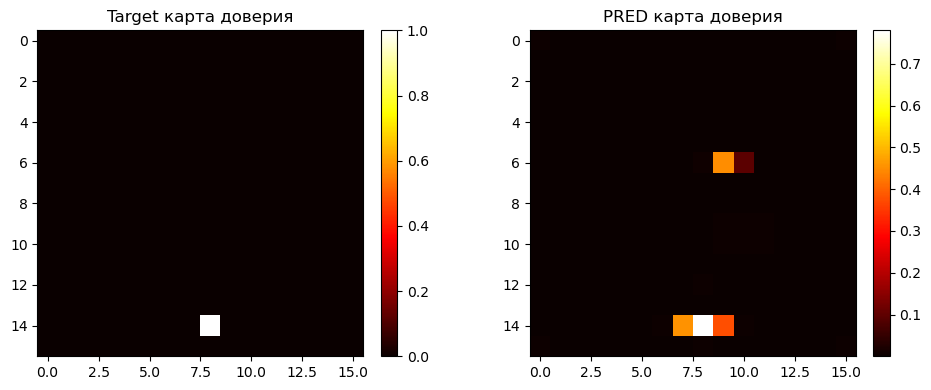

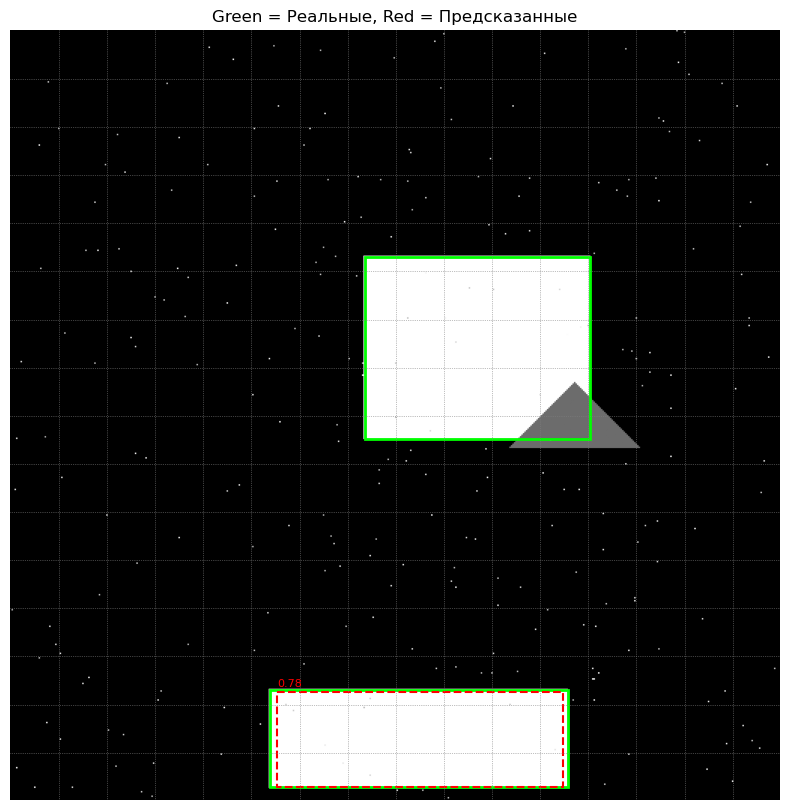

Эпоха 10: Train Loss=1.1356 | Val Loss=1.0889 | Train IoU=0.3278 | VAL IoU=0.4040
Сохранена лучшая модель.


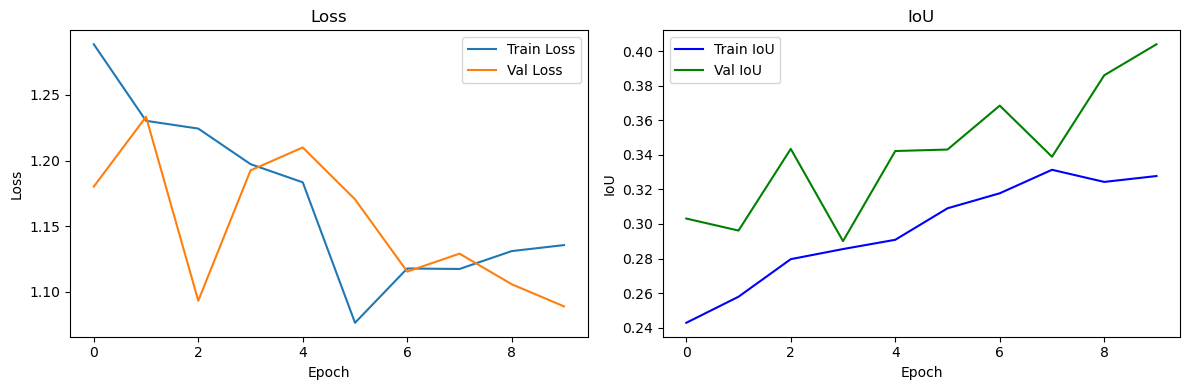

In [12]:
# Детекция прямоугольников
epochs=10
S=16
B=2
C=1
batch_size=8
save_path="models_custom/checkpoints"
name_model="best_sintetic_model.pth"
dataset = SyntheticYOLODataset(size=1500, img_size=512, S=S, B=B, C=C)


train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



model_path = os.path.join(save_path, name_model)

model = YOLOv1(S=S, B=B, C=C)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

lr=0.005

train_yolo(model, train_loader, val_loader, device, lr=lr, epochs=epochs, S=S, B=B, C=C, save_path=save_path, name_model=name_model)


### Реальный датасет

In [53]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

current_directory = os.getcwd()  

exp = 3
if exp == 0:    #  все объекты (UAVOD)
    target = 'dataset/dataset_mobileNet/dataset_2/target/'    
    labels_path = os.path.join(current_directory, target)  

    image = 'dataset/dataset_mobileNet/dataset_2/image/'    
    images_path = os.path.join(current_directory, image)  
elif exp == 1:  #  UAVOD  два объекта (автомобиль и лодка)
    target = 'dataset/dataset_mobileNet/dataset_4/target/'    
    labels_path = os.path.join(current_directory, target)  

    image = 'dataset/dataset_mobileNet/dataset_4/image/'    
    images_path = os.path.join(current_directory, image) 
elif exp == 2:  #  DOTA  три  объекта (автомобиль, самолёт и лодка)
    target = 'dataset/dataset_mobileNet/dataset_6/target/'    
    labels_path = os.path.join(current_directory, target)  

    image = 'dataset/dataset_mobileNet/dataset_6/image/'    
    images_path = os.path.join(current_directory, image) 
elif exp == 3:  #  DOTA и UAVOD три  объекта (автомобиль, самолёт и лодка)
    target = 'dataset/dataset_mobileNet/dataset_7/target/'    
    labels_path = os.path.join(current_directory, target)  

    image = 'dataset/dataset_mobileNet/dataset_7/image/'    
    images_path = os.path.join(current_directory, image) 


print("Пути к данным")
print(labels_path)
print(images_path)

dataset = YOLORealDataset(images_path=images_path, labels_path=labels_path, image_size=512)
img, target = dataset[0]
print(img.shape)      # -> torch.Size([3, 512, 512])
print(target.shape)   # -> torch.Size([16, 16, 2 * (5 + 10)])


Пути к данным
/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_mobileNet/dataset_7/target/
/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_mobileNet/dataset_7/image/
torch.Size([3, 512, 512])
torch.Size([16, 16, 12])


### Просмотр датасета

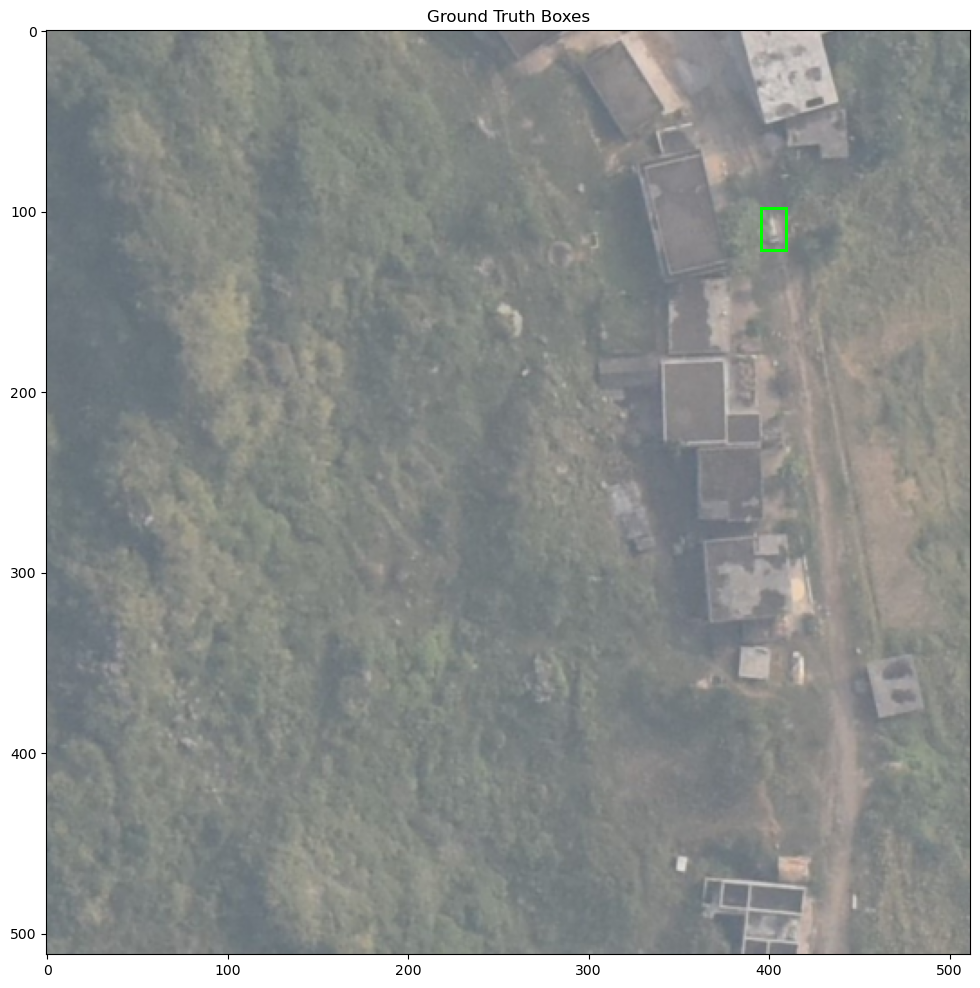

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from torch.utils.data import DataLoader
from IPython.display import clear_output

def show_dataset(dataset, S=16, B=2, C=1, delay=2, batch_size=1):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=yolo_collate_fn)
    for imgs, targets in dataloader:
        for i in range(imgs.size(0)):
            img_tensor = imgs[i].cpu()
            true_tensor = targets[i].cpu()
            
            # print("БОКСЫ ", true_tensor[0])
            # print("min:", true_tensor.min().item())
            # print("max:", true_tensor.max().item())

            # Визуализация
            draw_gt_boxes(img_tensor, true_tensor, S=S, B=B, C=C)
            time.sleep(delay)
            clear_output(wait=True)
        break

def draw_gt_boxes(img_tensor, true_tensor, S=1, B=2, C=1):
    img = img_tensor.permute(1, 2, 0).numpy()
    h, w = img.shape[:2]

    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)

    cell_size = w // S

    for y in range(S):
        for x in range(S):
            for b in range(B):
                base = b * (5 + C)
                if true_tensor[y, x, base + 4] > 0:
                    tx, ty, tw, th = true_tensor[y, x, base:base+4]
                    abs_x = (x + tx.item()) * cell_size
                    abs_y = (y + ty.item()) * cell_size
                    abs_w = tw.item() * w
                    abs_h = th.item() * h
                    rect = patches.Rectangle((abs_x - abs_w / 2, abs_y - abs_h / 2),
                                             abs_w, abs_h, linewidth=2, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)

    # plt.axis('off')
    plt.title("Ground Truth Boxes")
    plt.show()


show_dataset(dataset, S=16, B=2, C=1, delay=3)


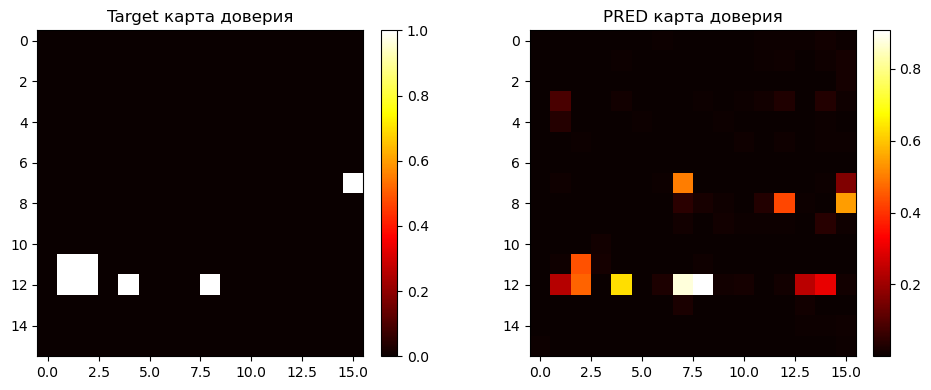

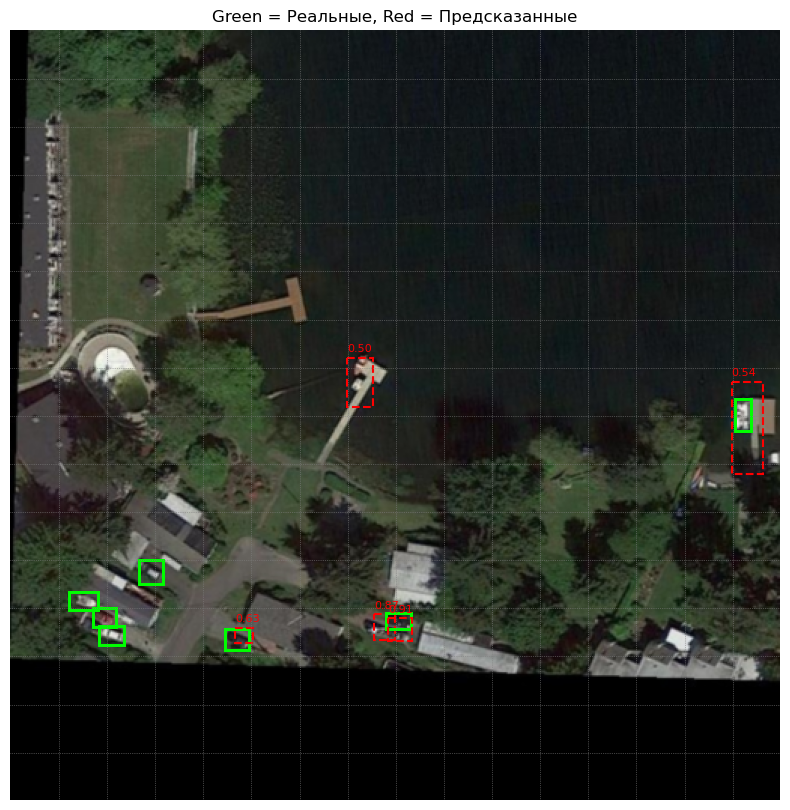

Эпоха 21: Train Loss=8.0946 | Val Loss=13.3734 | Train IoU=0.0239 | VAL IoU=0.0217
Улучшений нет. Patience: 5/5
Обучение остановлено.


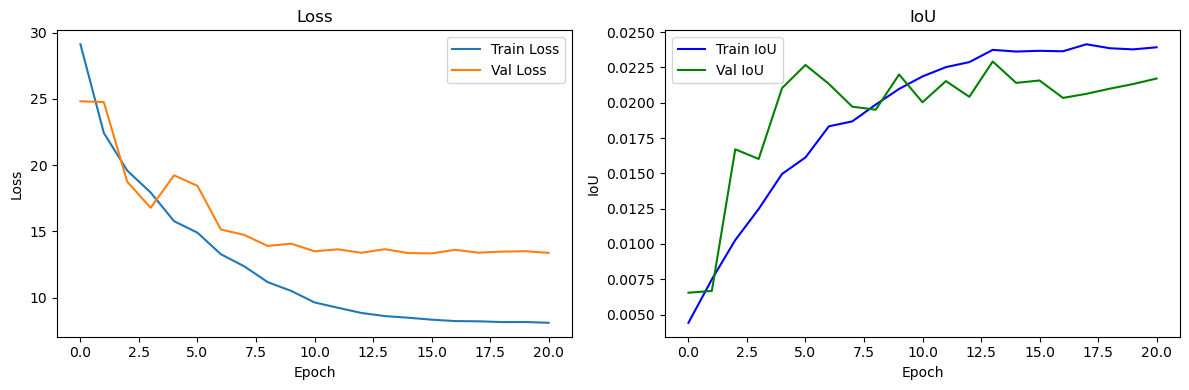

In [ ]:
epochs=25
S=16
B=2
C=1
lr=0.001
batch_size=32
save_path="models_custom/checkpoints"
name_model = "best_real_model_3.pth"
dataset = YOLORealDataset(images_path=images_path, labels_path=labels_path, image_size=512)

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=yolo_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=yolo_collate_fn)

model_path = os.path.join(save_path, name_model)

model = YOLOv1(S=S, B=B, C=C)

# model.initialize_weights()  # инициализация весов (для модели YOLOv2)

model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

tar = train_yolo(model, train_loader, val_loader, device, lr=lr, epochs=epochs, S=S, B=B, C=C, save_path=save_path, name_model=name_model)

## Использование модели

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torchvision.ops import nms
from PIL import Image

def inference_yolo(model, image_path, device, S=16, B=2, C=1, threshold=0.5, iou_thresh=0.4):
    model.eval()

    # ==============    Преобразование изображения 
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    # ===============   Предсказание 
    with torch.no_grad():
        preds = model(img_tensor)[0].cpu()  # (S, S, B*(5+C))

    img_np = img_tensor[0].permute(1, 2, 0).cpu().numpy()
    h, w = img_np.shape[:2]
    cell_size_x = w / S
    cell_size_y = h / S

    boxes = []
    confidences = []

    for y in range(S):
        for x in range(S):
            for b in range(B):
                base = b * (5 + C)
                conf = preds[y, x, base + 4].item()
                if conf < threshold:
                    continue

                px, py, pw, ph = preds[y, x, base:base+4]

                if not (0 <= px <= 1 and 0 <= py <= 1 and 0.01 <= pw <= 1.0 and 0.01 <= ph <= 1.0):
                    continue

                abs_x = (x + px) * cell_size_x
                abs_y = (y + py) * cell_size_y
                abs_w = pw * w
                abs_h = ph * h

                x1 = abs_x - abs_w / 2
                y1 = abs_y - abs_h / 2
                x2 = abs_x + abs_w / 2
                y2 = abs_y + abs_h / 2

                boxes.append([x1, y1, x2, y2])
                confidences.append(conf)

    if not boxes:
        print("Нет боксов выше порога.")
        return

    boxes = torch.tensor(boxes)
    scores = torch.tensor(confidences)

    keep = nms(boxes, scores, iou_thresh)

    # ===========    Отображение 
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_np)

    for idx in keep:
        x1, y1, x2, y2 = boxes[idx]
        conf = scores[idx]

        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{conf:.2f}", color='red', fontsize=9)

    ax.set_title("Найденные объекты")
    plt.axis('off')
    plt.show()


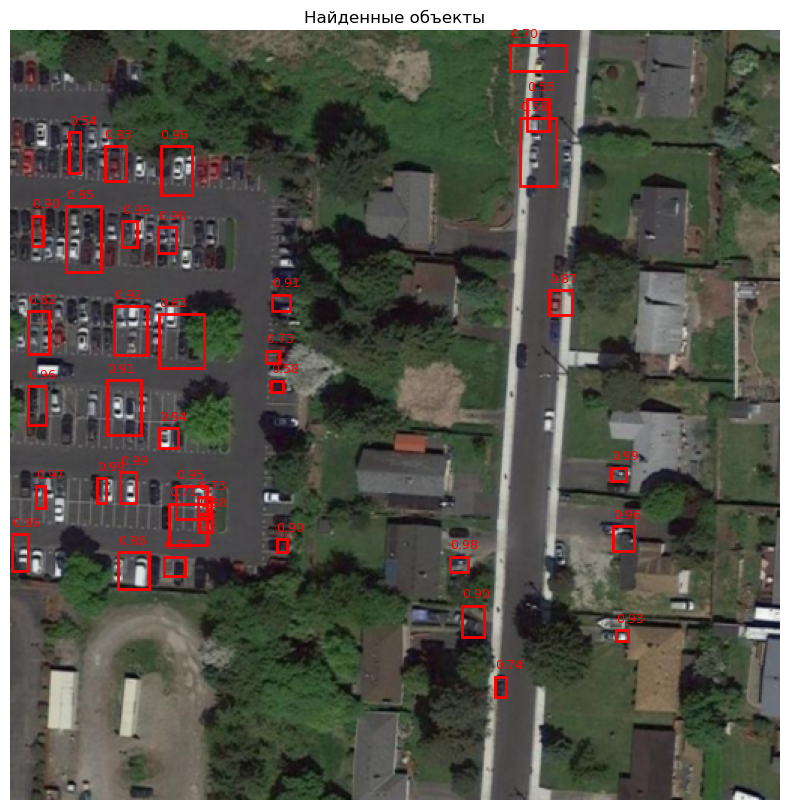

In [21]:
save_path="models_custom/checkpoints"
name_model = "best_real_model_3.pth"

model_path = os.path.join(save_path, name_model)

model = YOLOv1(S=16, B=2, C=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

patch_image = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset_mobileNet/dataset_7/image/P0020_2crop73.jpg"


inference_yolo(model, patch_image, device, S=16, B=2, C=1, threshold=0.5)


## ПАРАМЕТРЫ МОДЕЛИ

In [28]:
from ptflops import get_model_complexity_info


model = YOLOv1(S=16, B=2, C=1)

with torch.cuda.device(0):  
    macs, params = get_model_complexity_info(model, (3, 512, 512), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f'FLOPs: {macs}')
    print(f'Parameters: {params}')


FLOPs: 1.67 GMac
Parameters: 1.58 M


In [32]:
import torch.nn as nn

model = YOLOv1(S=16, B=2, C=1)

layer_count = sum(1 for layer in model.modules() if isinstance(layer, (nn.Conv2d, nn.BatchNorm2d, nn.ReLU, nn.LeakyReLU, nn.MaxPool2d, nn.Dropout)))
print(f"Количество слоёв: {layer_count}")





layer_count = sum(1 for _ in model.modules())
print(f"Всего слоёв (включая родительские): {layer_count}")


Количество слоёв: 25
Всего слоёв (включая родительские): 28


In [29]:
from torchinfo import summary


model = YOLOv1(S=16, B=2, C=1)
summary(model, input_size=(1, 3, 512, 512))


Layer (type:depth-idx)                   Output Shape              Param #
YOLOv1                                   [1, 16, 16, 12]           --
├─Sequential: 1-1                        [1, 256, 16, 16]          --
│    └─Conv2d: 2-1                       [1, 16, 512, 512]         448
│    └─BatchNorm2d: 2-2                  [1, 16, 512, 512]         32
│    └─LeakyReLU: 2-3                    [1, 16, 512, 512]         --
│    └─MaxPool2d: 2-4                    [1, 16, 256, 256]         --
│    └─Conv2d: 2-5                       [1, 32, 256, 256]         4,640
│    └─BatchNorm2d: 2-6                  [1, 32, 256, 256]         64
│    └─LeakyReLU: 2-7                    [1, 32, 256, 256]         --
│    └─MaxPool2d: 2-8                    [1, 32, 128, 128]         --
│    └─Conv2d: 2-9                       [1, 64, 128, 128]         18,496
│    └─BatchNorm2d: 2-10                 [1, 64, 128, 128]         128
│    └─LeakyReLU: 2-11                   [1, 64, 128, 128]         --
│    └

In [30]:
from torchviz import make_dot
import torch

model = YOLOv1(S=16, B=2, C=1)
dummy_input = torch.randn(1, 3, 512, 512)

output = model(dummy_input)
dot = make_dot(output, params=dict(list(model.named_parameters())))
dot.format = 'png'
dot.render('yolov1_architecture')  

'yolov1_architecture.png'

###  Архитектура модели

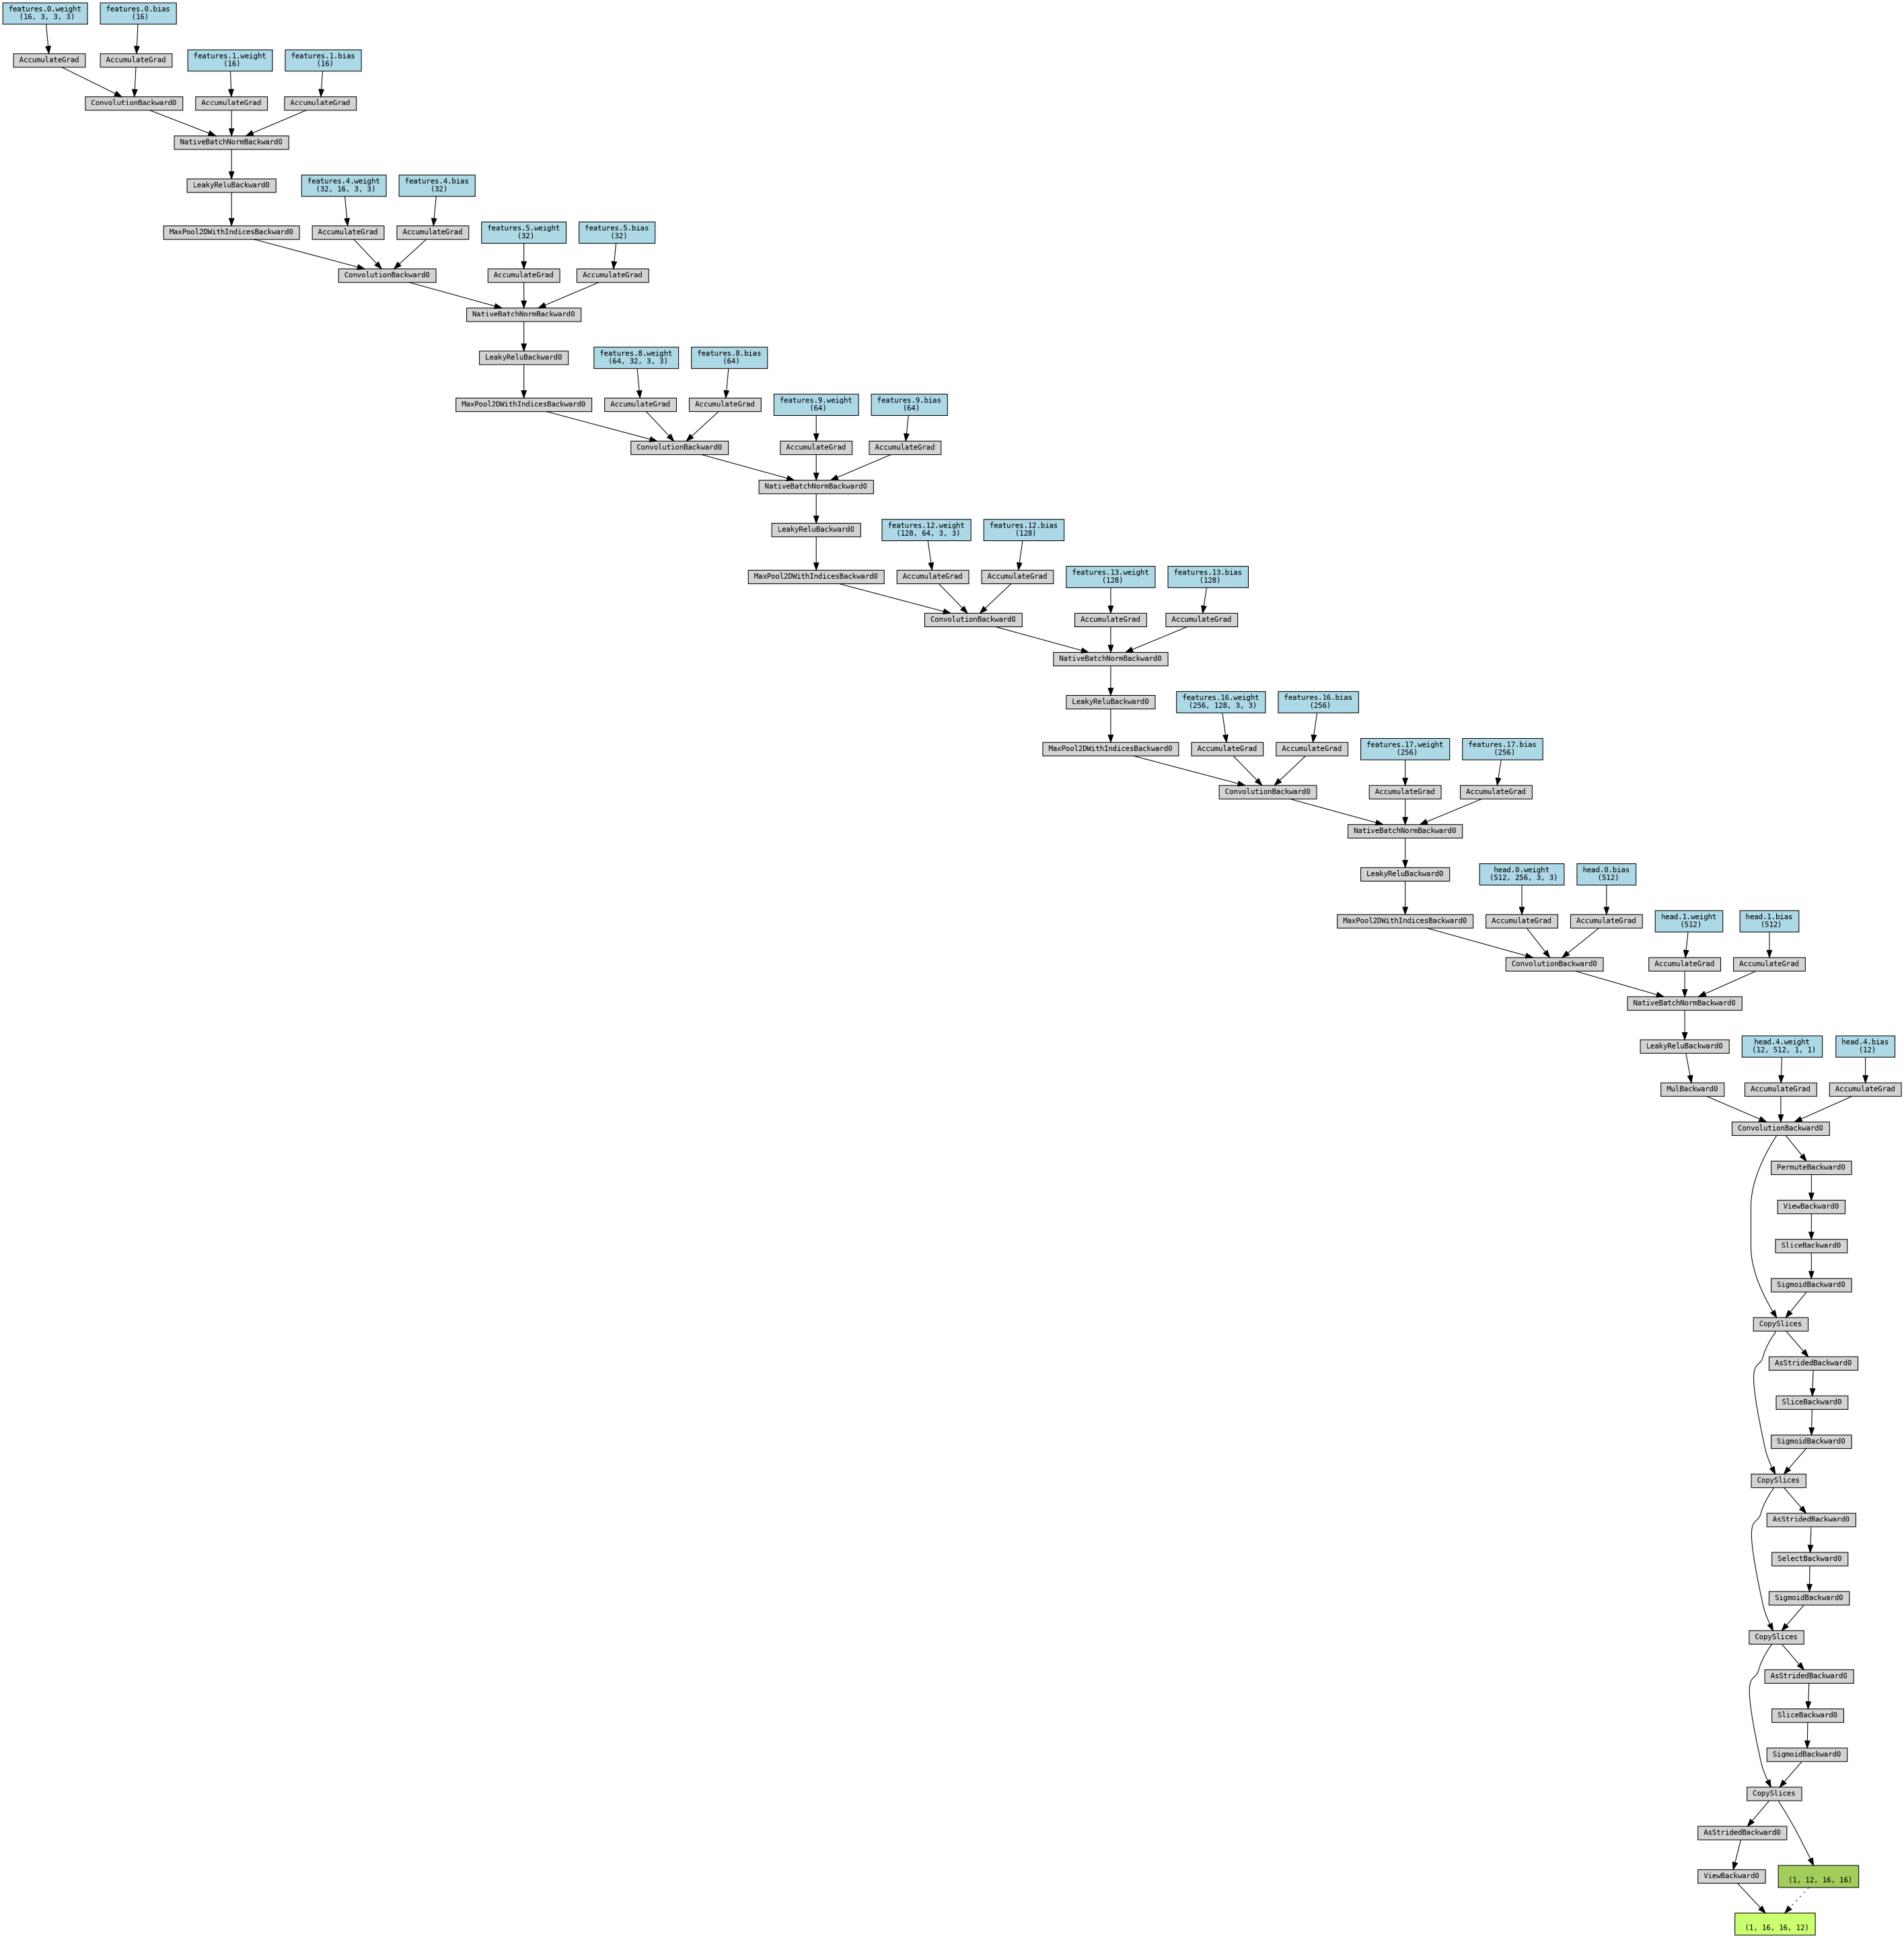

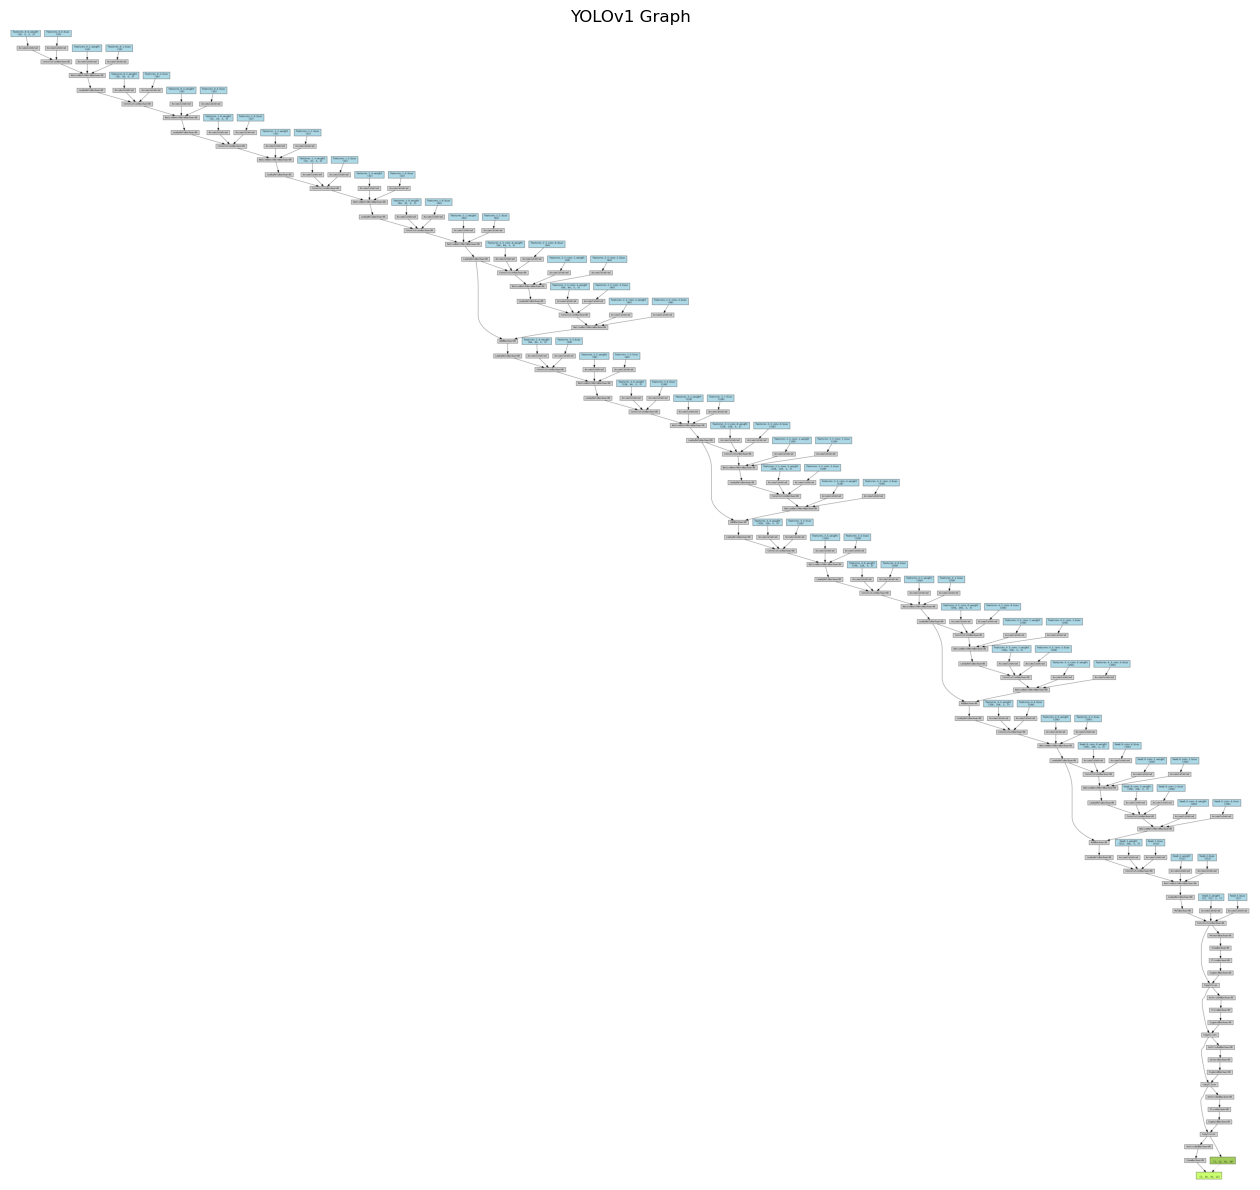

In [ ]:
import torch
from torchviz import make_dot
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

# Создание модели и фиктивного входа
model = YOLOv1(S=16, B=2, C=1)
dummy_input = torch.randn(1, 3, 512, 512)

# Вывод модели
output = model(dummy_input)

# Создание и сохранение графа
dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('yolo_graph', cleanup=True)

# Загрузка и отображение картинки
img = Image.open("yolo_graph.png")
plt.figure(figsize=(16, 16))
plt.imshow(img)
plt.axis('off')
plt.title("YOLOv1 Graph")
plt.show()
